# Tree-Grass ecosystem analysis

**License:** CC-BY-4.0  
**Github:** [https://github.com/BenjMy/centum](https://github.com/BenjMy/centum)  
**Subject:** Tutorial
**Authors**:

Benjamin Mary
  Email: [benjamin.mary@ica.csic.es](mailto:benjamin.mary@ica.csic.es)  
  ORCID: [0000-0001-7199-2885](https://orcid.org/0000-0001-7199-2885)  
  Affiliation: ICA-CSIC
  
**Date:** 2025/01/10


:::{note} Hypothesis
Irrigated agricultural areas can be distinguished from adjacent agricultural parcels or natural areas through a sudden increase in actual evapotranspiration which cannot be explained by other factors (e.g. change in weather or vegetation cover).
:::



:::{important}

For the **delineation** we will use two types of datasets: 
- Earth Observation induced actual ET (calculated from an energy balance model): those are 3d raster datasets(x,y,time);
- Only when dealing with real datasets: irrigation district shapefiles
:::

In order to make calculation we will use the xarray datarray library. This has the advantage to allow us to read directly netcdf file format a standart for large raster images processing/storing. 

In the following we use a synthetic dataset that describe a rain event at day 3. 

In [1]:
import pooch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from centum.irrigation_district import IrrigationDistrict 

In [2]:
pooch_Majadas = pooch.create(
    path=pooch.os_cache("Majadas_project"),
    base_url="https://github.com/BenjMy/test_Majadas_centum_dataset/raw/refs/heads/main/",
    registry={
        "20200403_LEVEL2_ECMWF_TPday.tif": None,
        "ETa_Majadas.netcdf": None,
        "ETp_Majadas.netcdf": None,
        "CLC_Majadas_clipped.shp": None,
        "CLC_Majadas_clipped.shx": None,
        "CLC_Majadas_clipped.dbf": None,
    },
)

Majadas_ETa_dataset = pooch_Majadas.fetch('ETa_Majadas.netcdf')
Majadas_ETp_dataset = pooch_Majadas.fetch('ETp_Majadas.netcdf')
Majadas_CLC_shapefile = pooch_Majadas.fetch('CLC_Majadas_clipped.shp')
Majadas_CLC_shapefile = pooch_Majadas.fetch('CLC_Majadas_clipped.dbf')
Majadas_CLC_shx = pooch_Majadas.fetch('CLC_Majadas_clipped.shx')

ETa_ds = xr.load_dataset(Majadas_ETa_dataset)
ETa_ds = ETa_ds.rename({"__xarray_dataarray_variable__": "ETa"})  # Rename the main variable to 'ETa'
ETp_ds = xr.load_dataset(Majadas_ETp_dataset)
ETp_ds = ETp_ds.rename({"__xarray_dataarray_variable__": "ETp"})  # Rename the main variable to 'ETa'
CLC = gpd.read_file(Majadas_CLC_shapefile)  # Load the CLC dataset

ETa_ds = ETa_ds

In [3]:
from pyproj import CRS
crs = CRS.from_wkt('PROJCS["unknown",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",53],PARAMETER["longitude_of_center",24],PARAMETER["false_easting",5837287.81977],PARAMETER["false_northing",2121415.69617],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')
ETa_ds.rio.write_crs(crs.to_wkt(), inplace=True)

<xarray.Dataset> Size: 23MB
Dimensions:      (band: 1, x: 54, y: 56, time: 1911)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 432B 3.324e+06 3.325e+06 ... 3.34e+06 3.34e+06
  * y            (y) float64 448B 1.179e+06 1.178e+06 ... 1.162e+06 1.162e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 15kB 2021-01-14 2021-03-10 ... 2021-04-17
Data variables:
    ETa          (time, band, y, x) float32 23MB 1.455 0.4689 ... 2.572 2.486

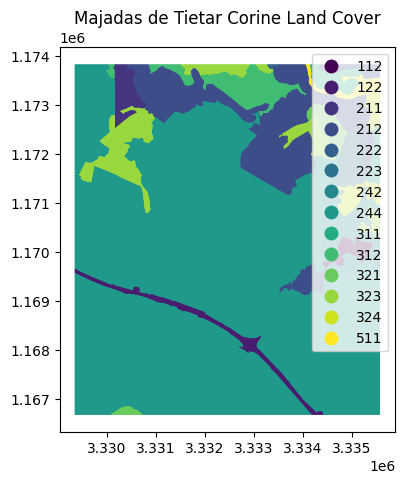

In [4]:
# Ensure the CRS matches
CLC.set_crs(crs.to_wkt(), inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
CLC.plot(column='Code_18', ax=ax, legend=True, cmap='viridis')
ax.set_title("Majadas de Tietar Corine Land Cover")
plt.show()

In [5]:
GeoAnalysis = IrrigationDistrict(Majadas_CLC_shapefile)
gdf_CLC = GeoAnalysis.load_shapefile()
resolution = 10
bounds = gdf_CLC.total_bounds  # (minx, miny, maxx, maxy)
gdf_CLC['index'] = gdf_CLC['Code_18']
clc_rxr = GeoAnalysis.convert_to_rioxarray(gdf=gdf_CLC, 
                                            variable="index", 
                                            resolution=resolution, 
                                            bounds=bounds
                                            )

In [6]:
clc_rxr.max()

<xarray.DataArray ()> Size: 4B
array(0, dtype=int32)

In [7]:
gdf_CLC['index']

0     244
1     244
2     244
3     511
4     511
     ... 
70    311
71    311
72    311
73    323
74    323
Name: index, Length: 75, dtype: object

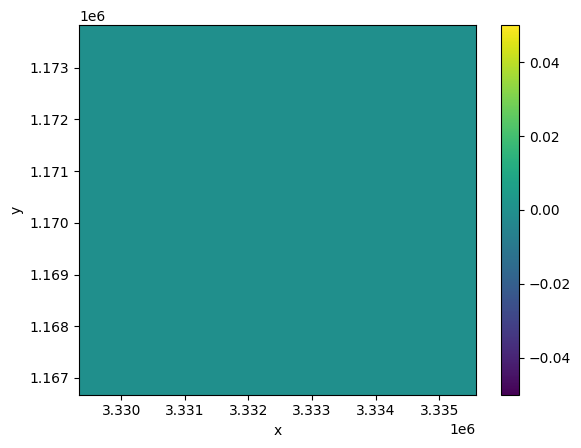

In [8]:
clc_rxr.plot.imshow()

In [9]:
clc_rxr = clc_rxr.rio.write_crs(crs.to_wkt())
ETa_ds = ETa_ds.rio.write_crs(crs.to_wkt())
clc_rxr = clc_rxr.rio.reproject_match(ETa_ds)


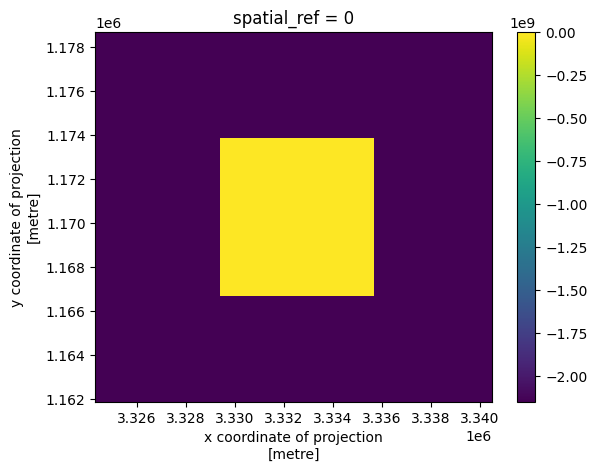

In [10]:
clc_rxr.plot.imshow()

In [11]:
results = []
# Loop through each land cover type in the GeoDataFrame
for land_cover, subset in CLC.groupby("Code_18"):
    try:
        # Ensure subset.geometry is a single geometry or a list of geometries
        combined_geometry = subset.geometry.unary_union
        # Clip the dataset using the combined geometry
        mask = ETa_ds['ETa'].rio.clip([combined_geometry], crs=subset.crs, drop=True)
        # Perform operations with the clipped dataset (e.g., calculate mean)
        spatial_mean = mask.mean(dim=["x", "y"], skipna=True)
        # Store the result
        results.append({"Code_18": land_cover, "ETa_mean": spatial_mean})
    except:
        pass
        
import pandas as pd
land_cover_means = pd.DataFrame(results)


AttributeError: 'function' object has no attribute 'plot'

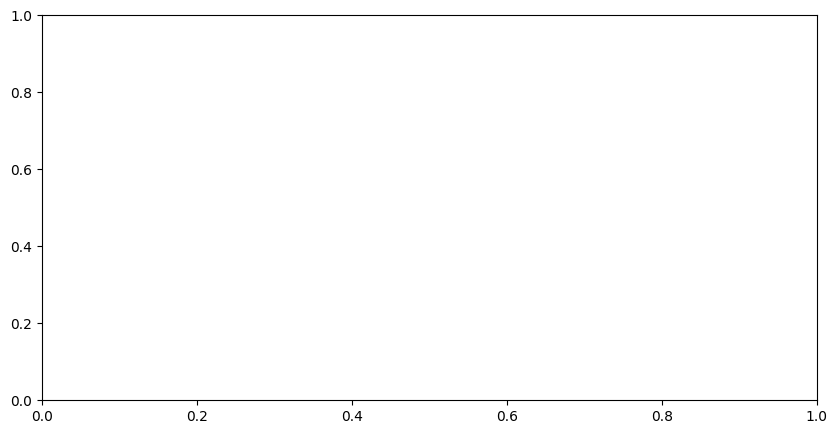

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
mask.isel.plot(column='Code_18', ax=ax, legend=True, cmap='viridis')
ax.set_title("Majadas de Tietar Corine Land Cover")
plt.show()

In [ ]:
land_cover_means.set_index('Code_18',inplace=True)

In [ ]:
mask.isel(band=0).isel(time=slice(0,8)).plot.imshow(x="x", y="y", 
                        col="time", 
                        col_wrap=4,
                        )

In [ ]:
# Agricultural areas
Agricultural_areas = land_cover_means.loc[land_cover_means.index.astype(str).str.startswith('1')]
Forest_areas = land_cover_means.loc[land_cover_means.index.astype(str).str.startswith('2')]


In [ ]:
fig, ax = plt.subplots()

for i in range(len(Agricultural_areas.index)):
    Agricultural_areas.iloc[i]['ETa_mean'].isel(band=0).plot.scatter(x='time',ax=ax,
                                                                    color='r',
                                                                     alpha=0.2
                                                                    )

for i in range(len(Agricultural_areas.index)):
    Forest_areas.iloc[i]['ETa_mean'].isel(band=0).plot.scatter(x='time',
                                                               ax=ax,
                                                              color='green',
                                                               alpha=0.2
                                                              )

In [ ]:
# Ensure the CRS matches
CLC.set_crs(crs.to_wkt(), inplace=True)

# Loop through unique land cover types to create masks and calculate means
results = []
for land_cover, subset in CLC.groupby("Code_18"):
    # Clip the ETa data to the current land cover geometry
    mask = ETa_ds.rio.clip(subset.geometry, crs=subset.crs, drop=True)
    # Calculate the mean ETa for the current land cover type
    spatial_mean = mask.mean().item()
    # Store the result
    results.append({"Code_18": land_cover, "ETa_mean": spatial_mean})

# Convert the results into a DataFrame for easier viewing
import pandas as pd
land_cover_means = pd.DataFrame(results)

In [ ]:
print(ETa_ds['ETa'].time)
print(ETp_ds['ETp'].time)

In [ ]:
ETa_ds['ETa'].isel(band=0).isel(time=slice(0,8)).time

In [ ]:
ETp_ds['ETp'].isel(band=0).isel(time=slice(0,8)).time

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
CLC.plot(column='Code_18', ax=ax, legend=True, cmap='viridis')
ax.set_title("Majadas de Tietar Corine Land Cover")
plt.show()

**Show Earth Observation time serie to analyse**

In [ ]:
ETp_ds['ETp'].isel(band=0).isel(time=slice(0,8)).plot.imshow(x="x", y="y", 
                        col="time", 
                        col_wrap=4,
                        )

In [ ]:
ETa_ds['ETa'].isel(band=0).isel(time=slice(0,8)).plot.imshow(x="x", y="y", 
                        col="time", 
                        col_wrap=4,
                        )